In [1]:
import ampal
import isambard
import isambard.specifications as specifications
import isambard.modelling as modelling
import isambard.optimisation as optimisation
import isambard.optimisation.evo_optimizers as ev_opts
from isambard.optimisation.evo_optimizers import Parameter
import budeff

import matplotlib.pyplot as plt
import numpy as np
import itertools
from pprint import pprint
import nglview as nv
from contextlib import redirect_stdout

%matplotlib inline

In [2]:
def show_ball_and_stick(ampal):
    view = nv.show_text(ampal.pdb)
    view.add_ball_and_stick()
    view.remove_cartoon()
    return view

In [3]:
class APHomoDimer(specifications.CoiledCoil):
    """Specification for creating anti-parallel, homodimeric coiled coils."""
    
    oligomeric_state = 2
    
    # The only thing that we need to define is a new `__init__` method, which defines
    # how the class is created. We get all the rest of the functionality off the
    # parent class `CoiledCoil`.
    def __init__(self, helix_length, radius, pitch, phica, zshift):
        # To kick everything off, this class runs the standard setup of the `CoiledCoil`
        # class, which gives our class all of the same attributes and methods. The
        # `super` function gives us access to the parent class. As we want to modify
        # some of the parameters before building the model, we set `auto_build` to false
        super().__init__(self.oligomeric_state, auto_build=False)
        
        # Next, we redefine the relevant default values that `CoiledCoil` has set. As
        # we have 2 helices, we have 2 values for each of these, but in this case they
        # are the same as we're making a homodimer
        self.aas = [helix_length, helix_length]
        self.major_radii = [radius, radius]
        self.major_pitches = [pitch, pitch]
        self.z_shifts = [0, zshift]
        self.phi_c_alphas = [phica, phica]
        
        # We need to set the orientation of the helices to be anti-parallel, so one
        # needs to have a +1 orientation and the other needs a -1 orientation
        self.orientations = [1, -1]

        # Now we've redefined these values, we need to build the model from these
        # parameters. We can do this using the build method, which comes from
        # `CoiledCoil`
        self.build()

In [4]:
REGISTER_ADJUST = {
    'a': 0,
    'b': 102.8,
    'c': 205.6,
    'd': 308.4,
    'e': 51.4,
    'f': 154.2,
    'g': 257
}

In [5]:
sequences = ['GQLEQELAALDQEIAAAEQELAALDWQIQG', 'GQLEQELAALDQEIAAAEQELAALDWQIQG']

In [6]:
def get_bude_total_energy(ampal_object):
    return budeff.get_internal_energy(ampal_object).total_energy

In [7]:
parameters = [
    optimisation.Parameter.static('Helix Length', 30),
    optimisation.Parameter.dynamic('Radius', 5.0, 1.0),
    optimisation.Parameter.dynamic('Pitch', 200, 60),
    optimisation.Parameter.dynamic('PhiCA', REGISTER_ADJUST['c'], 27),
    optimisation.Parameter.dynamic('ZShift', 10, 10),
]

In [8]:
default_values = [x.default_value for x in parameters]
print(default_values)

[30, 5.0, 200, 205.6, 10]


Genetic Algorithm

In [9]:
opt_ga = ev_opts.GA(APHomoDimer, sequences, parameters, get_bude_total_energy)

In [10]:
opt_ga.run_opt(100, 30, cores=8)

gen	evals	avg     	std    	min     	max     
0  	88   	-773.647	19.2937	-837.607	-748.872
1  	65   	-789.047	21.8857	-855.023	-762.226
2  	69   	-806.633	19.2083	-857.941	-776.492
3  	72   	-823.943	15.9596	-863.259	-801.393
4  	60   	-834.593	13.8576	-863.259	-814.504
5  	71   	-844.934	9.99225	-865.947	-826.373
6  	56   	-850.446	8.06097	-865.947	-835.091
7  	87   	-857.319	5.82259	-871.747	-848.017
8  	69   	-862.543	4.64508	-874.441	-852.908
9  	68   	-865.875	2.85259	-874.441	-859.887
10 	75   	-868.215	1.68595	-874.441	-865.947
11 	51   	-868.87 	1.75467	-874.441	-866.688
12 	81   	-870.152	1.84078	-875.522	-867.649
13 	85   	-871.782	1.39552	-875.758	-869.233
14 	61   	-872.63 	1.20922	-875.758	-870.562
15 	79   	-873.608	1.06783	-875.758	-871.902
16 	81   	-874.537	0.901585	-875.939	-872.793
17 	71   	-875.106	0.637941	-875.939	-873.631
18 	71   	-875.485	0.378454	-876.007	-874.359
19 	69   	-875.704	0.204781	-876.046	-875.245
20 	73   	-875.786	0.155221	-876.046	-875.446
21 	7

In [11]:
optimized_model_ga = opt_ga.best_model

In [12]:
budeff.get_internal_energy(optimized_model_ga).total_energy

-878.725235317755

In [13]:
funnel_data_ga = opt_ga.make_energy_funnel_data()

In [14]:
xs = [x[0] for x in funnel_data_ga]
ys = [x[1] for x in funnel_data_ga]
zs = [x[2] for x in funnel_data_ga]

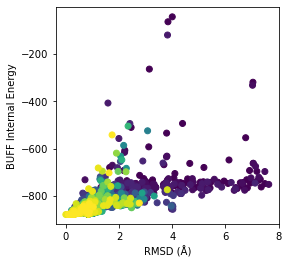

In [15]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('ga.png')

In [16]:
f = open('apCC-Di-AA_new-optimized-model-ga.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_ga.pdb)

Differential Evolution

In [17]:
opt_de = ev_opts.DE(APHomoDimer, sequences, parameters, get_bude_total_energy)

/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [18]:
opt_de.run_opt(100, 30, cores=8)

gen	evals	avg     	std    	min     	max     
0  	100  	-765.266	38.6316	-842.758	-574.256
1  	100  	-781.7  	24.7177	-861.103	-743.914
2  	100  	-790.22 	24.5501	-861.103	-747.401
3  	100  	-800.404	27.2294	-865.403	-750.78 
4  	100  	-814.102	27.7743	-869.689	-752.224
5  	100  	-826.144	23.856 	-869.689	-766.902
6  	100  	-837.616	18.3293	-870.727	-784.571
7  	100  	-844.3  	16.7431	-875.97 	-795.981
8  	100  	-852.819	14.5739	-876.254	-822.74 
9  	100  	-858.028	12.6036	-876.902	-827.93 
10 	100  	-863.588	9.8826 	-878.517	-834.821
11 	100  	-867.952	7.31469	-878.517	-845.44 
12 	100  	-870.513	6.36126	-880.103	-846.882
13 	100  	-873.107	4.44396	-880.103	-859.564
14 	100  	-875.129	3.31843	-880.103	-860.066
15 	100  	-876.668	2.18345	-880.103	-868.903
16 	100  	-877.685	1.27297	-880.103	-873.3  
17 	100  	-878.29 	1.06161	-880.411	-874.889
18 	100  	-878.697	0.883915	-880.411	-875.452
19 	100  	-879.094	0.630278	-880.411	-877.213
20 	100  	-879.322	0.438034	-880.411	-877.976
21 	100

In [19]:
optimized_model_de = opt_de.best_model
budeff.get_internal_energy(optimized_model_de).total_energy

-880.6179420144423

In [20]:
funnel_data_de = opt_de.make_energy_funnel_data()

In [21]:
xs = [x[0] for x in funnel_data_de]
ys = [x[1] for x in funnel_data_de]
zs = [x[2] for x in funnel_data_de]

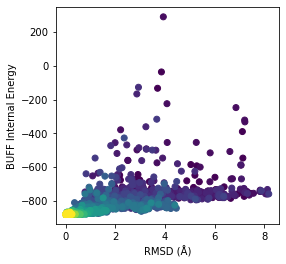

In [22]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('de.png')

In [23]:
f = open('apCC-Di-AA_new-optimized-model-de.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_de.pdb)

Particle Swarm Optimisation

In [24]:
opt_pso = ev_opts.PSO(APHomoDimer, sequences, parameters, get_bude_total_energy)

/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [25]:
opt_pso.run_opt(100, 30, cores=8)

gen	evals	avg     	std    	min     	max     
0  	100  	-709.798	135.449	-845.675	-201.933
1  	64   	-741.947	150.792	-874.763	-55.4124
2  	43   	-728.223	165.669	-874.763	-55.4124
3  	73   	-715.132	137.963	-844.84 	-111.629
4  	76   	-757.146	80.9989	-843.109	-111.629
5  	51   	-752.867	120.619	-864.766	-76.7735
6  	56   	-690.767	177.052	-859.557	-135.193
7  	58   	-692.979	154.049	-859.557	-135.193
8  	79   	-718.748	121.755	-849.503	-152.508
9  	83   	-760.587	96.4082	-876.412	-152.508
10 	59   	-717.219	179.205	-880.262	-77.2913
11 	41   	-724.338	167.112	-880.262	-77.2913
12 	74   	-754.028	106.432	-877.784	-196.737
13 	90   	-759.037	109.234	-891.387	-110.137
14 	64   	-731.869	176.546	-891.387	-2.76802
15 	30   	-745.392	149.112	-891.387	-2.76802
16 	21   	-753.248	121.625	-891.387	-207.922
17 	36   	-749.256	113.984	-859.48 	-232.421
18 	47   	-733.008	153.166	-859.48 	-14.6739
19 	23   	-732.071	153.148	-859.48 	-14.6739
20 	21   	-723.511	164.714	-859.48 	-14.6739
21 	21   	

In [26]:
optimized_model_pso = opt_pso.best_model
budeff.get_internal_energy(optimized_model_pso).total_energy

-891.3866142549571

In [27]:
funnel_data_pso = opt_pso.make_energy_funnel_data()

In [28]:
xs = [x[0] for x in funnel_data_pso]
ys = [x[1] for x in funnel_data_pso]
zs = [x[2] for x in funnel_data_pso]

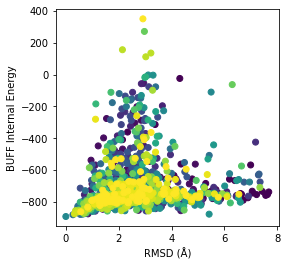

In [29]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('pso.png')

In [30]:
f = open('apCC-Di-AA_new-optimized-model-pso.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_pso.pdb)

Covariance Matrix Adaptive Evolutionary Strategy

In [31]:
opt_cmaes = ev_opts.CMAES(APHomoDimer, sequences, parameters, get_bude_total_energy)

/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [32]:
opt_cmaes.run_opt(100, 30, cores=8)

gen	evals	avg     	std    	min     	max     
0  	100  	-732.674	70.4841	-810.957	-378.844
1  	100  	-737.964	96.6673	-809.487	-90.9812
2  	100  	-758.898	55.0785	-814.903	-350.231
3  	100  	-777.002	37.7516	-846.931	-631.905
4  	100  	-792.365	41.4581	-858.075	-641.64 
5  	100  	-795.394	54.1863	-883.047	-550.508
6  	100  	-824.794	39.1897	-882.117	-653.898
7  	100  	-829.381	52.4986	-877.649	-480.555
8  	100  	-852.427	24.2416	-878.749	-740.246
9  	100  	-864.921	10.023 	-879.31 	-832.036
10 	100  	-868.897	7.24343	-879.567	-845.252
11 	100  	-871.05 	5.69624	-879.453	-844.804
12 	100  	-873.02 	4.63256	-879.094	-857.931
13 	100  	-875.517	3.55073	-879.71 	-864.935
14 	100  	-875.875	4.43868	-880.541	-856.067
15 	100  	-875.663	5.5334 	-880.011	-856.269
16 	100  	-878.075	3.53985	-880.412	-855.455
17 	100  	-878.653	2.79356	-880.428	-859.59 
18 	100  	-878.954	2.14048	-880.552	-865.854
19 	100  	-879.253	2.27659	-880.582	-858.015
20 	100  	-878.371	3.04291	-880.556	-859.348
21 	100  	

In [33]:
optimized_model_cmaes = opt_cmaes.best_model
budeff.get_internal_energy(optimized_model_cmaes).total_energy

-883.0471359120771

In [34]:
funnel_data_cmaes = opt_cmaes.make_energy_funnel_data()

In [35]:
xs = [x[0] for x in funnel_data_cmaes]
ys = [x[1] for x in funnel_data_cmaes]
zs = [x[2] for x in funnel_data_cmaes]

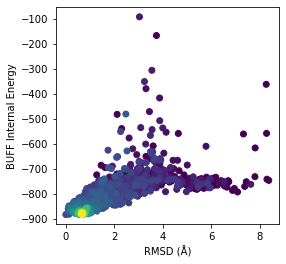

In [36]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('cmaes.png')

In [37]:
f = open('apCC-Di-AA_new-optimized-model-cmaes.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_cmaes.pdb)